# Setup

## Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Installs

In [ ]:
!pip install sentence_transformers -q

     |████████████████████████████████| 85 kB 4.4 MB/s 
     |████████████████████████████████| 4.7 MB 59.7 MB/s 
     |████████████████████████████████| 1.3 MB 53.7 MB/s 
     |████████████████████████████████| 101 kB 12.7 MB/s 
     |████████████████████████████████| 596 kB 73.6 MB/s 
     |████████████████████████████████| 6.6 MB 56.3 MB/s 


## Paths

In [ ]:
DATASET_CSABSTRUCT_DIR = './gdrive/Shareddrives/DATASETS/CSAbstruct/'
MODEL = './gdrive/Shareddrives/MODELS/scibert_scivocab_uncased_CSAbstruct_TripletAll-2022-08-08_12-07-03/model'

## Imports

In [ ]:
import pandas as pd

pd.options.display.max_columns = 100
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 300
pd.options.mode.chained_assignment = 'raise'

import json

from tqdm import tqdm

import torch

# Load CSAbstruct Dataset

In [ ]:
df_train = pd.read_parquet(DATASET_CSABSTRUCT_DIR + 'train.parquet')
df_dev = pd.read_parquet(DATASET_CSABSTRUCT_DIR + 'dev.parquet')
df_test = pd.read_parquet(DATASET_CSABSTRUCT_DIR + 'test.parquet')

In [ ]:
# same text but with different labels
print(f'{len(df_train.index)}')
mask = df_train.groupby('sentence')['label_id'].transform('nunique') > 1
df_train = df_train[~mask].copy()
print(f'{len(df_train.index)}')

11333
11250


In [ ]:
# same text but with different labels
print(f'{len(df_dev.index)}')
mask = df_dev.groupby('sentence')['label_id'].transform('nunique') > 1
df_dev = df_dev[~mask].copy()
print(f'{len(df_dev.index)}')

2026
2024


In [ ]:
# same text but with different labels
print(f'{len(df_test.index)}')
mask = df_test.groupby('sentence')['label_id'].transform('nunique') > 1
df_test = df_test[~mask].copy()
print(f'{len(df_test.index)}')

1349
1349


In [ ]:
train_sentences = list(df_train['sentence'].values)
dev_sentences = list(df_dev['sentence'].values)
test_sentences = list(df_test['sentence'].values)

print(f'train_sentences: {len(train_sentences)}')
print(f'dev_sentences: {len(dev_sentences)}')
print(f'test_sentences: {len(test_sentences)}')

train_sentences: 11250
dev_sentences: 2024
test_sentences: 1349


In [ ]:
y_train_true = list(df_train['label_id'].values)
y_dev_true = list(df_dev['label_id'].values)
y_test_true = list(df_test['label_id'].values)

print(f'y_train_true: {len(y_train_true)}')
print(f'y_dev_true: {len(y_dev_true)}')
print(f'y_test_true: {len(y_test_true)}')

y_train_true: 11250
y_dev_true: 2024
y_test_true: 1349


# Fine Tuned Model

In [ ]:
from sentence_transformers import models, SentenceTransformer

tuned_model = SentenceTransformer(MODEL, device='cuda')

# Tests

## Generate Embeddings

In [ ]:
%time embeddings_gpu_train = tuned_model.encode(train_sentences, convert_to_tensor=True, show_progress_bar=True)
embeddings_cpu_train = embeddings_gpu_train.cpu().numpy()
embeddings_cpu_train.shape

Batches:   0%|          | 0/352 [00:00<?, ?it/s]

CPU times: user 26.8 s, sys: 716 ms, total: 27.5 s
Wall time: 30.8 s


(11250, 768)

In [ ]:
%time embeddings_gpu_dev = tuned_model.encode(dev_sentences, convert_to_tensor=True, show_progress_bar=True)
embeddings_cpu_dev = embeddings_gpu_dev.cpu().numpy()
embeddings_cpu_dev.shape

Batches:   0%|          | 0/64 [00:00<?, ?it/s]

CPU times: user 4.36 s, sys: 22.2 ms, total: 4.39 s
Wall time: 4.44 s


(2024, 768)

In [ ]:
%time embeddings_gpu_test = tuned_model.encode(test_sentences, convert_to_tensor=True, show_progress_bar=True)
embeddings_cpu_test = embeddings_gpu_test.cpu().numpy()
embeddings_cpu_test.shape

Batches:   0%|          | 0/43 [00:00<?, ?it/s]

CPU times: user 2.98 s, sys: 17.6 ms, total: 2.99 s
Wall time: 3.04 s


(1349, 768)

## Unsupervised

In [ ]:
from sklearn.cluster import KMeans

num_clusters = len(set(y_test_true))

kmeans_clusterer = KMeans(n_clusters=num_clusters)
%time kmeans_cluster_labels = kmeans_clusterer.fit_predict(embeddings_cpu_test)
len(kmeans_cluster_labels)

CPU times: user 639 ms, sys: 595 ms, total: 1.23 s
Wall time: 1.03 s


1349

In [ ]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import rand_score
from sklearn.metrics import mutual_info_score


print(f'Adjusted RI {adjusted_rand_score(y_test_true, kmeans_cluster_labels):.4f}')
print(f'RI {rand_score(y_test_true, kmeans_cluster_labels):.4f}')
print(f'Adjusted MI {adjusted_mutual_info_score(y_test_true, kmeans_cluster_labels):.4f}')
print(f'MI {mutual_info_score(y_test_true, kmeans_cluster_labels):.4f}')
print(f'Silhouette Score {silhouette_score(embeddings_cpu_test, kmeans_cluster_labels):.4f}')

Adjusted RI 0.5060
RI 0.8069
Adjusted MI 0.4723
MI 0.6757
Silhouette Score 0.3045


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


CPU times: user 12.3 s, sys: 234 ms, total: 12.6 s
Wall time: 13.9 s


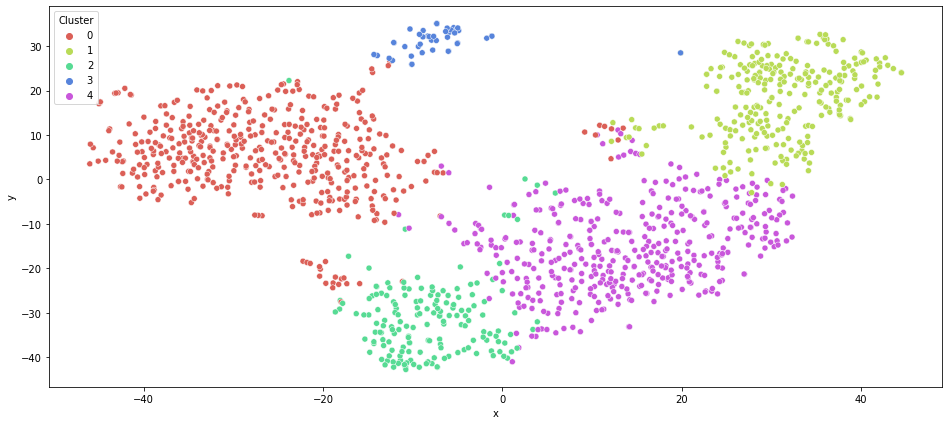

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tSNE=TSNE(n_components=2, init='pca')

%time tSNE_result=tSNE.fit_transform(embeddings_cpu_test)

df_kmeans = pd.DataFrame.from_dict({'x':tSNE_result[:,0],'y':tSNE_result[:,1],'Cluster':kmeans_cluster_labels})

plt.figure(figsize=(16,7))
ax = sns.scatterplot(x='x',y='y',hue='Cluster',palette=sns.color_palette("hls",num_clusters),data=df_kmeans,
               legend="full")

plt.show()

## Supervised

In [ ]:
import math

total = math.ceil(math.sqrt(len(train_sentences)))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models = [
    ('DecisionTreeClassifier', tree.DecisionTreeClassifier()),
    ('KNeighborsClassifier1', KNeighborsClassifier(n_neighbors=1, weights='distance')),
    ('KNeighborsClassifierSqrt', KNeighborsClassifier(n_neighbors=total, weights='distance')),
    ('KNeighborsClassifier5', KNeighborsClassifier(weights='distance')),
    ('RandomForestClassifier', RandomForestClassifier()),
    ('MLPClassifier', MLPClassifier()),
]

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score
import time

output_results = []

for model in models:
  output_dict = {
      'model': model[0]
  }
  print(model[0])
  clf = model[1]
  start = time.time()
  clf = clf.fit(embeddings_cpu_train, y_train_true)
  end = time.time()
  y_pred = clf.predict(embeddings_cpu_test)
  
  output_dict['acc'] = accuracy_score(y_test_true, y_pred)
  output_dict['f1_macro'] = f1_score(y_test_true, y_pred, average='macro')
  output_dict['f1_micro'] = f1_score(y_test_true, y_pred, average='micro')  
  output_dict['f1_weighted'] = f1_score(y_test_true, y_pred, average='weighted')
  output_dict['time'] = end - start
  
  output_results.append(output_dict)
pd.DataFrame(output_results)

DecisionTreeClassifier
KNeighborsClassifier1
KNeighborsClassifierSqrt
KNeighborsClassifier5
RandomForestClassifier
MLPClassifier


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


,model,acc,f1_macro,f1_micro,f1_weighted,time
0,DecisionTreeClassifier,0.694589,0.668365,0.694589,0.696630,39.396311
1,KNeighborsClassifier1,0.687176,0.662895,0.687176,0.687200,0.010108
2,KNeighborsClassifierSqrt,0.776130,0.755643,0.776130,0.772083,0.010521
3,KNeighborsClassifier5,0.763529,0.739420,0.763529,0.760005,0.010027
4,RandomForestClassifier,0.779837,0.775069,0.779837,0.778914,57.330728
5,MLPClassifier,0.710156,0.696217,0.710156,0.711877,48.309132


In [ ]:
models = [
  ('SVM', SVC()),
]

In [ ]:
output_results = []

for model in models:
  output_dict = {
      'model': model[0]
  }
  print(model[0])
  clf = model[1]
  start = time.time()
  clf = clf.fit(embeddings_cpu_train, y_train_true)
  end = time.time()
  y_pred = clf.predict(embeddings_cpu_test)
  
  output_dict['acc'] = accuracy_score(y_test_true, y_pred)
  output_dict['f1_macro'] = f1_score(y_test_true, y_pred, average='macro')
  output_dict['f1_micro'] = f1_score(y_test_true, y_pred, average='micro')  
  output_dict['f1_weighted'] = f1_score(y_test_true, y_pred, average='weighted')
  output_dict['time'] = end - start
  
  output_results.append(output_dict)
pd.DataFrame(output_results)

SVM


,model,acc,f1_macro,f1_micro,f1_weighted,time
0,SVM,0.756857,0.749787,0.756857,0.755026,23.949058
